<div style="text-align: center;">
<h1>The University of North Carolina at Chapel Hill</h1>
<h1>Comp 555 BioAlgorithms - Spring 2018</h1>
<h1 style="font-size: 250%;">Problem Set #2 </h1>
<h1>Issued Tuesday, 2/19/2019; Due Tuesday, 3/5/2019</h1>
</div>

**Homework Information:** Some of the problems are probably too long to be done the night before the due date, so plan accordingly. Late problem sets will be penalized by a factor of	70.71% for each class meeting after the due date. Feel free to get help from others, but **the work you submit in should be your own.**

**Warning:** This notebook has been annotated with metadata so that it can be uploaded to the grading system. It is very important that you enter your answers in the provided cells. You can add extra cells to explore approaches, but only the provided cell can and will be graded. Thus, if you delete a cell and add a replacement, there is a possiblity that your problem will not be graded. If you ever need to start over, you should download a new version of the problem set and transfer your solutions to it.

In [1]:
# Replace the following string values with the requested information
class Student:
    first = "Benjamin"
    last = "Fawcett"
    onyen = "bfawcett"
    pid = "730095208"

You will need three datasets for this problem set. The first is a collection of gene promoter regions in which you will search for <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/motifs.fa" download="motifs.txt">transcription binding factor motifs</a>. The second is a set of 15 base-pair <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/reads.fa" download="reads.txt">simulated reads</a> from a genome that will be used for assembly. The third is a small genome that will be used for substring searching <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/GenomeB.fa" download="GenomeB.txt">GenomeB.fa</a>.

The cell below provides various functions and imports necessary for this problem set. Do not import any addtional packages. Also, make sure that you ***run the following cell***.

In [2]:
import itertools
import math
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

def loadFasta(filename):
    """ Parses a classically formatted and possibly 
        compressed FASTA file into two lists. One of 
        headers and a second list of sequences.
        The ith index of each list correspond."""
    if (filename.endswith(".gz")):
        fp = gzip.open(filename, 'r')
    else:
        fp = open(filename, 'r')
    # split at headers
    data = fp.read().split('>')
    fp.close()
    # ignore whatever appears before the 1st header
    data.pop(0)     
    headers = []
    sequences = []
    for sequence in data:
        lines = sequence.split('\n')
        headers.append(lines.pop(0))
        # add an extra "+" to make string "1-referenced"
        sequences.append('+' + ''.join(lines))
    return (headers, sequences)

class Graph:
    def __init__(self, vlist=[]):
        """ Initialize a Graph with an optional vertex list """
        self.index = {v:i for i,v in enumerate(vlist)}
        self.vertex = {i:v for i,v in enumerate(vlist)}
        self.edge = []
        self.edgelabel = []
    def addVertex(self, label):
        """ Add a labeled vertex to the graph """
        index = len(self.index)
        self.index[label] = index
        self.vertex[index] = label
    def addEdge(self, vsrc, vdst, label='', repeats=True):
        """ Add a directed edge to the graph, with an optional label. 
        Repeated edges are distinct, unless repeats is set to False. """
        e = (self.index[vsrc], self.index[vdst])
        if (repeats) or (e not in self.edge):
            self.edge.append(e)
            self.edgelabel.append(label)
    def hamiltonianPath(self):
        """ A Brute-force method for finding a Hamiltonian Path. 
        Basically, all possible N! paths are enumerated and checked
        for edges. Since edges can be reused there are no distictions
        made for *which* version of a repeated edge. """
        for path in itertools.permutations(sorted(self.index.values())):
            for i in xrange(len(path)-1):
                if ((path[i],path[i+1]) not in self.edge):
                    break
            else:
                return [self.vertex[i] for i in path]
        return []
    def SearchTree(self, path, verticesLeft):
        """ A recursive Branch-and-Bound Hamiltonian Path search. 
        Paths are extended one node at a time using only available
        edges from the graph. """
        if (len(verticesLeft) == 0):
            self.PathV2result = [self.vertex[i] for i in path]
            return True
        for v in verticesLeft:
            if (len(path) == 0) or ((path[-1],v) in self.edge):
                if self.SearchTree(path+[v], [r for r in verticesLeft if r != v]):
                    return True
        return False
    def hamiltonianPathV2(self):
        """ A wrapper function for invoking the Branch-and-Bound 
        Hamiltonian Path search. """
        self.PathV2result = []
        self.SearchTree([],sorted(self.index.values()))                
        return self.PathV2result
    def degrees(self):
        """ Returns two dictionaries with the inDegree and outDegree
        of each node from the graph. """
        inDegree = {}
        outDegree = {}
        for src, dst in self.edge:
            outDegree[src] = 0
            outDegree[dst] = 0
            inDegree[src] = 0
            inDegree[dst] = 0
            
        for src, dst in self.edge:
            outDegree[src] = outDegree.get(src) + 1
            inDegree[dst] = inDegree.get(dst) + 1
            
        return inDegree, outDegree
    def verifyAndGetStart(self):
        inDegree, outDegree = self.degrees()
        start = 0
        end = 0
        for vert in self.vertex.keys():
            ins = inDegree.get(vert,0)
            outs = outDegree.get(vert,0)
            if (ins == outs):
                continue
            elif (ins - outs == 1):
                end = vert
            elif (outs - ins == 1):
                start = vert
            else:
                start, end = -1, -1
                break
        if (start >= 0) and (end >= 0):
            return start
        else:
            return -1
    def eulerianPath(self):
        graph = [(src,dst) for src,dst in self.edge]
        currentVertex = self.verifyAndGetStart()
        path = [currentVertex]
        # "next" is where vertices get inserted into our tour
        # it starts at the end (i.e. it is the same as appending),
        # but later "side-trips" will insert in the middle
        next = 1
        while len(graph) > 0:
            for edge in graph:
                if (edge[0] == currentVertex):
                    currentVertex = edge[1]
                    graph.remove(edge)
                    path.insert(next, currentVertex)
                    next += 1
                    break
            else:
                for edge in graph:
                    try:
                        next = path.index(edge[0]) + 1
                        currentVertex = edge[0]
                        break
                    except ValueError:
                        continue
                else:
                    print("There is no path!")
                    return False
        return path
    
    
    def eulerEdges(self, path):
        edgeList = self.vertex.get(path[0])
        for i in range(1,len(path)):
            edgeList = edgeList + self.vertex.get(path[i])[-1]
            
        return edgeList
    
    def render(self, highlightPath=[]):
        """ Outputs a version of the graph that can be rendered
        using graphviz tools (http://www.graphviz.org/)."""
        edgeId = {}
        for i in xrange(len(self.edge)):
            edgeId[self.edge[i]] = edgeId.get(self.edge[i], []) + [i]
        edgeSet = set()
        for i in xrange(len(highlightPath)-1):
            src = self.index[highlightPath[i]]
            dst = self.index[highlightPath[i+1]]
            edgeSet.add(edgeId[src,dst].pop())
        result = ''
        result += 'digraph {\n'
        result += '   graph [nodesep=2, size="10,10"];\n'
        for index, label in self.vertex.iteritems():
            result += '    N%d [shape="box", style="rounded", label="%s"];\n' % (index, label)
        for i, e in enumerate(self.edge):
            src, dst = e
            result += '    N%d -> N%d' % (src, dst)
            label = self.edgelabel[i]
            if (len(label) > 0):
                if (i in edgeSet):
                    result += ' [label="%s", penwidth=3.0]' % (label)
                else:
                    result += ' [label="%s"]' % (label)
            elif (i in edgeSet):
                result += ' [penwidth=3.0]'                
            result += ';\n'                
        result += '    overlap=false;\n'
        result += '}\n'
        return result

---
**Problem #1:** In the cell below use the *MedianStringMotifSearch()*, and *ScanAndScoreMotif()* functions given in class to find an optimal 8-base motif pattern and its location in each of the 20 given promoter regions in <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/motifs.fa" download="motifs.txt">motifs.fa</a>. Based on this result, make a prediction of how long it would have taken to find an optimal 10-base motif.

In [3]:
# copy the MedianStringMotifSearch(), and ScanAndScoreMotif() 
# functions here and run them using the given code fragment.

def ScanAndScoreMotif(DNA, motif):
    totalDist = 0
    bestAlignment = []
    k = len(motif)
    for seq in DNA:
        minHammingDist = k+1
        for s in range(len(seq)-k+1):
            HammingDist = sum([1 for i in range(k) if motif[i] != seq[s+i]])
            if (HammingDist < minHammingDist):
                bestS = s
                minHammingDist = HammingDist
        bestAlignment.append(bestS)
        totalDist += minHammingDist
    return bestAlignment, totalDist

def MedianStringMotifSearch(DNA,k):
    """ Consider all possible 4**k motifs"""
    bestAlignment = []
    minHammingDist = k*len(DNA)
    kmer = ''
    for pattern in itertools.product('acgt', repeat=k):
        motif = ''.join(pattern)
        align, dist = ScanAndScoreMotif(DNA, motif)
        if (dist < minHammingDist):
            bestAlignment = [p for p in align]
            minHammingDist = dist
            kmer = motif
    return bestAlignment, minHammingDist, kmer

header, dna = loadFasta("data/motifs.fa")

%time MedianStringMotifSearch(dna,8) 

CPU times: user 5min 51s, sys: 713 ms, total: 5min 51s
Wall time: 5min 53s


([129,
  48,
  125,
  92,
  84,
  57,
  177,
  27,
  180,
  48,
  50,
  106,
  149,
  165,
  38,
  114,
  26,
  4,
  4,
  119],
 19,
 'caccgccc')

---
**Problem #2:** A simple optimization can be applied to *MedianStringMotifSearch()* as follows: If ever during the *ScanAndScoreMotif()* function the Hamming distance (i.e. *totalDistance*) exceeds the smallest Hamming distance seen thus far, the scanning through sequences can be terminated early. Implement this strategy and use it to search for the best 10-base motif. (Note: this requires that you do one at least of the following, add an additional argument to the *ScanAndScoreMotif()*, create a global variable shared by both *BetterMedianStringMotifSearch()* and *ScanAndScoreMotif()*, or encapuslate *ScanAndScoreMotif()* as an inner function of *BetterMedianStringMotifSearch()*). Run your new optimized version and report its run time. This optimization is technically not a branch-and-bound strategy; explain why?

In [4]:
# Modify the MedianStringMotifSearch(), and ScanAndScoreMotif() 
# functions here and run them using the given code fragment.

def ScanAndScoreMotif1(DNA, motif, smallest):
    totalDist = 0
    bestAlignment = []
    k = len(motif)
    for seq in DNA:
        if (totalDist > smallest):
            return bestAlignment, totalDist
        else:
            minHammingDist = k+1
            for s in range(len(seq)-k+1):
                HammingDist = sum([1 for i in range(k) if motif[i] != seq[s+i]])
                if (HammingDist < minHammingDist):
                    bestS = s
                    minHammingDist = HammingDist
            bestAlignment.append(bestS)
            totalDist += minHammingDist
    return bestAlignment, totalDist

def BetterMedianStringMotifSearch(DNA,k):
    """ Consider all possible 4**k motifs"""
    bestAlignment = []
    minHammingDist = k*len(DNA)
    kmer = ''
    for pattern in itertools.product('acgt', repeat=k):
        motif = ''.join(pattern)
        align, dist = ScanAndScoreMotif1(DNA, motif, minHammingDist)
        if (dist < minHammingDist):
            bestAlignment = [p for p in align]
            minHammingDist = dist
            kmer = motif
    return bestAlignment, minHammingDist, kmer

%time BetterMedianStringMotifSearch(dna,10)

CPU times: user 56min 1s, sys: 5.26 s, total: 56min 6s
Wall time: 56min 16s


([128,
  47,
  124,
  91,
  83,
  56,
  176,
  26,
  179,
  47,
  49,
  105,
  148,
  164,
  37,
  113,
  25,
  3,
  3,
  118],
 25,
 'tcaccgcccg')

---
**Problem #3:** The *ContainedMotifSearch()* algortihm from lecture 5 can be used to find a heuristic solution for the motif search problem considerably faster than the *MedianStringMotifSearch()*. However, this solution may not be best overall solution. *ContainedMotifSearch()* can still be used to speed up *MedianStringMotifSearch()* using the following approach: First, use ContainedMotifSearch() to first establish an initial upper-bound for the Hamming distance. Then, use it as an intitial setting of the minimum Hamming distance used in *MedianStringMotifSearch()*. Also, consider how the prefixes of candidate motifs can be used to determine if further extensions might possibly beat the *ContainedMotifSearch()* solution. This last change makes the algorithm truely "branch-and-bound" and requires that succesive *patterns* be generated using a different approach than the itertools product used in *MedianStringMotifSearch()*.

In the cell provided below write *BestMedianMotifSearch()*.

In [5]:
# THIS CELL WILL BE GRADED
# This cell should include *ALL* functions called by BestMedianMotifSearch(),
# such as ContainedMedianSearch() and ScanAndScoreMotif(). Any test or 
# validation code should be placed in another cell 



def ContainedMotifSearch(DNA,k):
    """ Consider only motifs from the given DNA sequences"""
    motifSet = set()
    for seq in DNA:
        for i in range(len(seq)-k+1):
            motifSet.add(seq[i:i+k])
    bestAlignment = []
    minHammingDist = k*len(DNA)
    kmer = ''
    for motif in motifSet:
        align, dist = ScanAndScoreMotif2(DNA, motif, minHammingDist)
        if (dist < minHammingDist):
            bestAlignment = [s for s in align]
            minHammingDist = dist
            kmer = motif
    return bestAlignment, minHammingDist, kmer

def ScanAndScoreMotif2(DNA, motif, smallest):
    totalDist = 0
    bestAlignment = []
    k = len(motif)
    for seq in DNA:
        if (totalDist > smallest):
            return bestAlignment, totalDist
        else:
            minHammingDist = k+1
            for s in range(len(seq)-k+1):
                HammingDist = sum([1 for i in range(k) if motif[i] != seq[s+i]])
                if (HammingDist < minHammingDist):
                    bestS = s
                    minHammingDist = HammingDist
            bestAlignment.append(bestS)
            totalDist += minHammingDist
    return bestAlignment, totalDist

def BestMedianMotifSearch(DNA,k):
    bestAlignment = []
    kmer = ''
    # Add your code here
    
    best, minH, kmr = ContainedMotifSearch(DNA,k)
    
    minHammingDist = minH
    prefixes = ['a','c','g','t']
    bases = ['a','c','g','t']
    
    for i in range (2,k):
        newprefixes = []
        for j in prefixes:
            for k in bases:
                motif = j+k
                align, dist = ScanAndScoreMotif2(DNA, motif, minHammingDist)
                if (dist <= minHammingDist):
                    newprefixes.append(motif)
        prefixes = newprefixes
        
    for i in prefixes:
        for j in bases:
            motif = i+j
            align, dist = ScanAndScoreMotif2(DNA, motif, minHammingDist)
            if (dist < minHammingDist):
                bestAlignment = [s for s in align]
                minHammingDist = dist
                kmer = motif
    return bestAlignment, minHammingDist, kmer

The following cell below is provided for testing your code. You should test it on <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/motifs.fa" download="motifs.txt">motifs.fa</a>. This cell will not be considered during grading.

In [6]:
header, dna = loadFasta("data/motifs.fa")
%time BestMedianMotifSearch(dna,10)

CPU times: user 2min 21s, sys: 159 ms, total: 2min 21s
Wall time: 2min 21s


([128,
  47,
  124,
  91,
  83,
  56,
  176,
  26,
  179,
  47,
  49,
  105,
  148,
  164,
  37,
  113,
  25,
  3,
  3,
  118],
 25,
 'tcaccgcccg')

**Problem #4:** A file of 15-mers simulating short reads from a genome can be <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/reads.fa" download="reads.txt">downloaded here</a>. How many distinct nodes appear in the De Bruijn graph that represents these 15-mers as edges? How many nodes are semi-balenced? How many nodes are balanced? How many are balanced with both in-degrees and out-degrees equal to 1?

In [7]:
# This cell is provided for your own use in answering problem 4. It will not be graded.
def debruijn(dna):
    nodes = []
    for seq in dna:
        b = seq[1:-1]
        e = seq[2:]
        if not b in nodes:
            nodes.append(b)
        if not e in nodes:
            nodes.append(e)

    G1 = Graph(nodes)
    for seq in dna:
        b = seq[1:-1]
        e = seq[2:]
        
        G1.addEdge(b, e)
    
    print("Number of Nodes = ", len(nodes))
    
    indeg, outdeg = G1.degrees()
    
    semi = 0
    for x in indeg.keys():
        if (indeg.get(x) - outdeg.get(x)) in [1,-1]:
            semi += 1
            print(x)
            print(G1.vertex.get(x))
    
    print("Number of semi-balanced nodes = ", semi)
    
    
    bal = 0
    for x in indeg.keys():
        if (indeg.get(x) - outdeg.get(x)) == 0:
            bal += 1
            
    print("Number of balanced nodes = ", bal)
    
    
    exc = 0
    for x in indeg.keys():
        if ((indeg.get(x) - outdeg.get(x)) == 0) and (indeg.get(x) == 1):
            exc += 1
            
    print("Number of balanced nodes with 1 in and out = ", exc)
    
    path = G1.eulerianPath()
    
    print("Eulerian path start = ", G1.vertex.get(path[0]))
    pathString = G1.eulerEdges(path)
    
    return pathString

header, dna = loadFasta("data/reads.fa")
eulerPath = debruijn(dna)

Number of Nodes =  98450
81230
GTTATACAGAGA
84773
GTGAGGATATAT
Number of semi-balanced nodes =  2
Number of balanced nodes =  98448
Number of balanced nodes with 1 in and out =  97044
Eulerian path start =  GTGAGGATATAT


**Problem #5:** What is the length of the Eulerian path that can be constructed in the De Bruijn graph described in Problem #4? It should be an assembled contig from the genome <a href="http://csbio.unc.edu/mcmillan/Comp555S19/data/GenomeB.fa" download="GenomeB.txt">GenomeB.fa</a>. Find the starting position of this assembled sequence in that genome.

Eulerian path is of length =  100000

540000 - 549999 : 5956
550000 - 559999 : 9150
560000 - 569999 : 9173
570000 - 579999 : 9101
580000 - 589999 : 9095
590000 - 599999 : 8792
600000 - 609999 : 9311
610000 - 619999 : 9274
620000 - 629999 : 9201
630000 - 639999 : 9034
640000 - 649999 : 3186
790000 - 799999 : 83
800000 - 809999 : 11
810000 - 819999 : 334
1780000 - 1789999 : 30

Starting position = 543528

First 77 bases in Euler path contig found accurately in genome B.


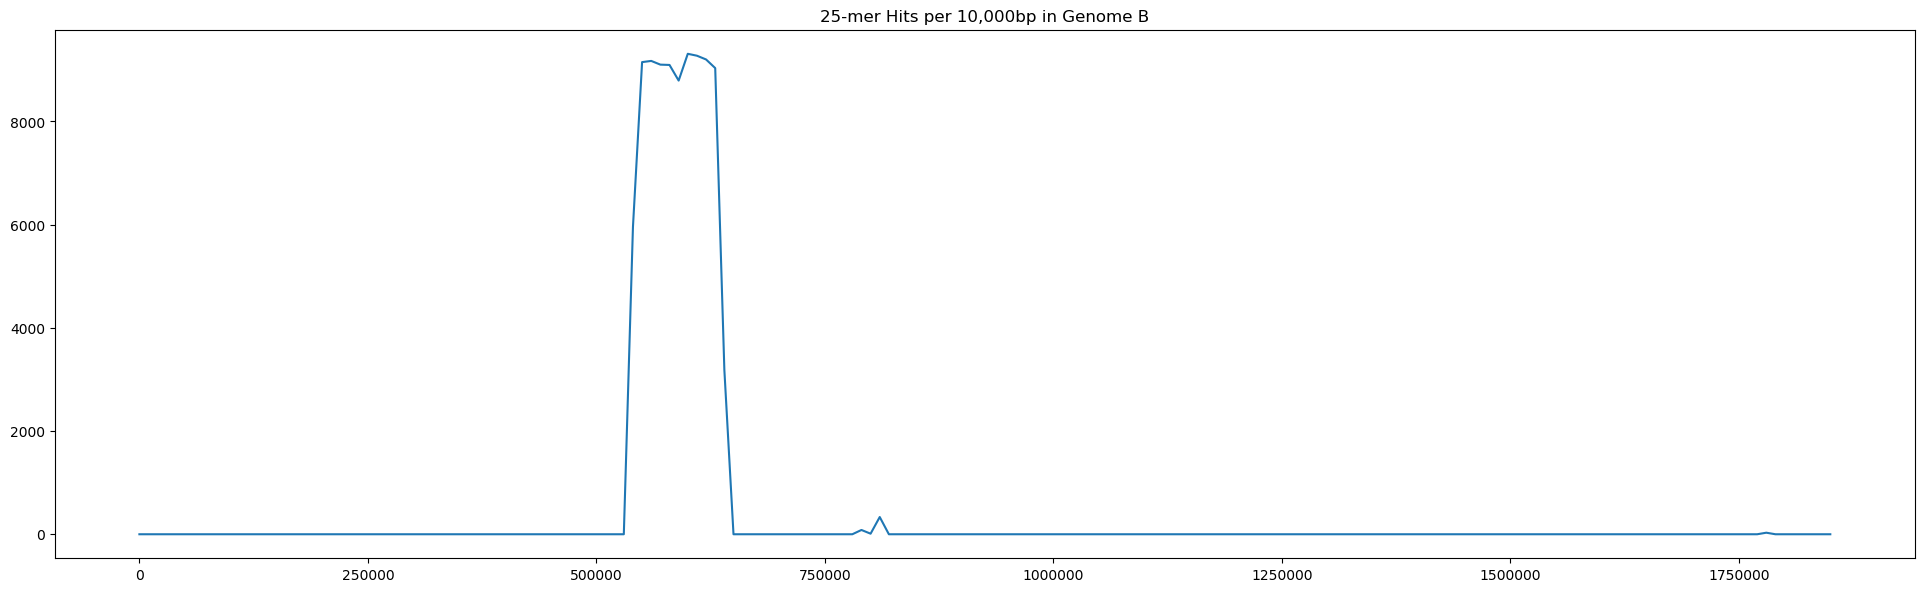

In [8]:
# This cell is provided for your own use in answering problem 5. It will not be graded.
header, dna = loadFasta("data/GenomeB.fa")
dna = dna[0]

print("Eulerian path is of length = ", len(eulerPath))
print()

kmers = set()
k = 25
for i in range(len(eulerPath)-k+1):
    kmers.add(eulerPath[i:i+k])
    
kmerInGenome = []
for i in range(len(dna)-k+1):
    kmerInGenome.append(int(dna[i:i+k] in kmers))
    
x = []
y = []
for s in range(0, len(dna), 10000):
    x.append(s)
    y.append(sum(kmerInGenome[s:s+10000]))
    if(sum(kmerInGenome[s:s+10000]) > 0):
        print(s, "-", s+9999, ":", sum(kmerInGenome[s:s+10000]))
        
        
print()
start = 0

for i in range(len(dna)-k+1):
    if(dna[i:i+k] == eulerPath[0:k]):
        start = i
        print("Starting position =", i)

count = 0
for i in range(len(eulerPath)):
    if(dna[start+i] == eulerPath[i]):
        count += 1
    else:
        break

print()
print("First", count, "bases in Euler path contig found accurately in genome B.")
    
plt.figure(num=None, figsize=(24, 7), dpi=100)
plt.title("25-mer Hits per 10,000bp in Genome B", fontdict=None, loc='center', pad=None)
result = plt.plot(x, y)

---

## Instructions for submitting your problem set

When you are ready to submit a version of your problem set, follow the instructions below.

1. Press [Save and Checkpoint] on the *File* menu of your Jupyter notebook.
2. Press the link below, which will take you to a website for submitting your problem set.
3. Choose the ***correct problem set number*** from the pull-down, else you might overwrite an earlier submission.
4. Enter in your onyen and PID in the form provided, then upload your submission.

Click [here to submit](http://csbio.unc.edu/mcmillan/index.py?run=PS.upload) your completed problem set

**Instructions for resubmissions:**

1. You may resubmit as many times as you like before the deadline. 
2. Resubmissions *always* overwrite any earlier submissions. 
3. If you resubmit after the due date, you will be warned of any penalties. 
4. Problem sets will not be regraded.